In [1]:
import pandas as pd
import numpy as np
import xml.etree
import matplotlib.pyplot as plt
import seaborn as sns
from implementations import *
import csv
import gzip
import xml.etree.ElementTree as ET
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk import pos_tag
import nltk
import spacy
import numpy.random as random
from matplotlib.ticker import FuncFormatter
#% warnings.filterwarnings("ignore")
import math
import json

# nltk.download('averaged_perceptron_tagger')

In [2]:
# load data
#df = pd.read_csv('characters_descriptions.csv')
movie_md = load_movie_md()
df1 = pd.read_csv('characters_actions.csv')

### How we get the final dataframe with all actions

In [28]:
def upper(word):
    return word[0].isupper()

df = df[~df['action'].apply(upper)]

In [68]:
nlp = spacy.load("en_core_web_sm")
#doc = nlp('i ' + word)[0].tag_[:2]=='VB'
#doc[0].tag_[:2]

def is_VB2(word):
    return (nlp('i ' + word)[1].tag_[:2]=='VB')&(nlp('he ' + word)[1].tag_[:2]=='VB')


def is_VB(word):
    return (pos_tag(nltk.word_tokenize('he ' + word))[1][1][:2]=='VB')&(pos_tag(nltk.word_tokenize('i ' + word))[1][1][:2]=='VB')

In [30]:
# lemmatize verbs and uppercase them
#df['action'] = df['action'].apply(str.lower)
#df = df[df['action'].apply(is_VB2)]
lemmatizer = WordNetLemmatizer()
df['action'] = df['action'].apply(lambda x: lemmatizer.lemmatize(x,'v'))

#### Some final treatments

In [6]:
df = df1

In [7]:
irrelevant_words = ['\'s', 'and', 'with', 'of', 'to', 'by', 'for', 'in', 'is', 'he', 'has', 'from', 'as',
                   'his', 'on', 'dr.', 'a', 'john', 'drs.', 'father', 'son', 'friend', 
                   'daughter', 'wife', 'mother', 'family', 'sister', 'brother', 'man', 'men', 'captain', 
                   'singh', 'jack', 'king', 'girl', 'woman', 'girlfriend', 'mary', 'husband', 'parent', 
                   'lady', 'children', 'white', 'car', 'room', 'annie', 'lady', 'queen', 'boy', 'student', 
                    'the', 'friends', 'her', 'home', 'ann', 'anne', 'aunt', 'father', 'girl', 'jane', 
                   'man', 'ms.', 'princess', 'sir', 'sister', 'snow', 'brothers', 'mrs.', 'mrs', 'mr', 
                    'winter', 'apartment', 'mr.', 'widow', 'jim', 'larry', 'van', 'officer',
                   'pregnant', 'teacher', 'relationship', 'team', 'socialite', 'maid', 'distraught', 
                   'susan', 'elizabeth', 'anna', 'l', 'sentence', 'steve', 'charlie', '|', 'heartbroken', 
                   'kitty', 'fred', 'boyfriend', 'eddie', 'wealthy', 'delight', 'wound', 'upset', 
                   'alex', 'de', 'crew', 'harry', 'ryan', 'lisa', 'adam', 'place', 'fire', ]

conditions = (df['action']!='')

for irr_wrd in list(set(irrelevant_words)):
    conditions = conditions&(df['action']!=irr_wrd)
    
act_df_treated = df[conditions]

char_description_total = act_df_treated.merge(movie_md, left_on ='movie id', right_on = 'Wikipedia movie ID')
epochs = [1914, 1945, 1970, 1990, 2000, 2007, 2022]
df_epochs = [char_description_total.query('`Movie release date` >=' + str(epochs[i]+1) + ' and `Movie release date` <= ' + str(epochs[i+1])) for i in range(len(epochs)-1)]

## Analyze interesting words in all

In [6]:
# interesting words for which we have to show the percentage :

women_interesting_words = ['prostitute', 'marry', 'love', 'kiss', 'attract', 'engage', 'date', 
                           'separate','sleep', 'seduce', 'miss', 'spend', 'flirt', 'touch', 
                           'propose', 'dance', 'divorce', 'bed']

men_interesting_words = ['gun', 'corrupt', 'compete', 'order', 'beat', 'destroy', 'deal', 
                         'eliminate', 'engineer', 'assassinate', 'lead', 'hire', 
                         'shoot', 'fight', 'kill', 'direct', 'detain']

In [7]:
male_description = char_description_total[char_description_total['actor gender']=='M']
female_description = char_description_total[char_description_total['actor gender']=='F']

m = male_description.groupby('action', as_index = False).count()[['action', 'actor name']]
m['actor name'] *= 100/male_description.shape[0]
f = female_description.groupby('action', as_index = False).count()[['action', 'actor name']]
f['actor name'] *= 100/female_description.shape[0]
merged_df = m.merge(f, on = 'action', suffixes=('_m', '_f'))
merged_df['freq_ratio'] = merged_df['actor name_m']/merged_df['actor name_f']
print('male actions size is    : {}'.format(male_description.shape[0]))
print('female actions size is  : {}'.format(female_description.shape[0]))

frequencies_women = {action: (merged_df[merged_df['action']==action].freq_ratio.values) for action in women_interesting_words}
frequencies_men = {action: (merged_df[merged_df['action']==action].freq_ratio.values) for action in men_interesting_words}

male actions size is    : 1034335
female actions size is  : 489670


In [8]:
frequencies_women

{'prostitute': array([0.20385498]),
 'marry': array([0.42922347]),
 'love': array([0.44345229]),
 'kiss': array([0.45452742]),
 'attract': array([0.54690919]),
 'engage': array([0.82252021]),
 'date': array([0.42390213]),
 'separate': array([0.56007436]),
 'sleep': array([0.56954546]),
 'seduce': array([0.53843369]),
 'miss': array([0.6637451]),
 'spend': array([0.74269204]),
 'flirt': array([0.38416486]),
 'touch': array([0.59000263]),
 'propose': array([0.97847273]),
 'dance': array([0.40490621]),
 'divorce': array([0.49646547]),
 'bed': array([0.5884815])}

In [9]:
frequencies_men

{'gun': array([2.71109154]),
 'corrupt': array([4.01157164]),
 'compete': array([2.16982006]),
 'order': array([2.16890259]),
 'beat': array([2.83311765]),
 'destroy': array([1.7847162]),
 'deal': array([1.72822032]),
 'eliminate': array([2.42751242]),
 'engineer': array([1.79760587]),
 'assassinate': array([2.10078033]),
 'lead': array([1.48103459]),
 'hire': array([1.377119]),
 'shoot': array([2.03905581]),
 'fight': array([2.15285792]),
 'kill': array([1.70967389]),
 'direct': array([1.84188135]),
 'detain': array([2.32920321])}

### some usefull functions and lists of words for further analysis

In [13]:
## here are some list of verbs assiociated with interesting subjects for the comparison male/female in movies

violence = ['anger', 'arrest', 'assassinate', 'assault', 'attack', 'beat', 'confront', 
            'defeat', 'defend', 'destroy', 'die', 'eliminate', 'enrage', 'fight', 'harass',
            'hurt', 'hunt', 'imprison', 'kick', 'kill', 'knock', 'murder', 'shoot', 
            'threaten', 'torture', 'gun',"attack","beat","bludgeon","box","buffet","club",
            "damage","devastate","disable","exert","fight","harm","hit","hurt","injure",
            "manhandle","maul","maim","pommel","pound","punch","ravage","rough","savage",
            "strike","thrash","thump","wallop","wound","murder","slay","assassinate",
            "eliminate","execute","liquidate","dispatch","massacre","exterminate","butcher",
            "decimate","extinguish","remove","eradicate","finish","snuff","fight","arrest",
            "abduct",    "ambush",    "assassinate",    "attack",    "beat",    "berate",    
            "bully",    "burn",    "choke",    "coerce",    "conquer",    "corrupt",   
            "decimate",    "defeat",    "destroy",    "devastate",    "disarm",    
            "disembowel",    "disintegrate",    "dismember",    "electrocute",    
            "enslave",    "exterminate",    "fear",    "fight",    "flog",    "gag",    
            "gang up on",    "gouge",    "grind",    "harm",    "hate",    "haunt",   
            "humiliate",    "hunt",    "intimidate",    "invade",    "isolate",    
            "lynch",    "massacre",    "maul",    "murder",    "mutilate",    "oppress",
            "overpower",    "persecute",    "pillage",    "plunder",    "poison",   
            "pound",    "rape",    "ravage",    "ravish",    "rebel",    "remorse", 
            "repress",    "resort",    "rob",    "sabotage",    "savage",    "scald", 
            "slaughter",    "smash",    "strangle",    "terrorize",    "torture",  
            "trample",    "tyrannize",    "undermine",    "vanquish",    "vandalize",
            "violate",    "wage",    "whip",    "wound"]
violence = list(set(violence))

love_seduction = ['seduce', 'prostitute', 'miss', 'marry', 'love', 'kiss', 'engage', 'date', 
                  'attract', 'flirt', 'divorce', 'cheat', 'dance', 'sleep', 'separate', 'sleep', 
                  'touch', "adore", "desire",'seduce', 'prostitute', 'miss', 'marry', 'love', 'kiss', 'engage', 'date', 
                  'attract', 'flirt', 'divorce', 'cheat', 'dance', 'sleep', 'separate', 'sleep','touch',     
                  "lust", "attract", "infatuate", "devote", "admirate", "care", 
                  "concern", "warmth",  "sentiment", "intimacy",
                  "closeness", "connection", "attachment", "bond", "union", "relationship", 
                  "commitment",     "faithfulness", "loyalty", "devote", "care", "concern", 
                  "fondness", "warmth",     "sentimentality", "sentiment", "empathy", "intimacy", 
                  "closeness", "connection",     "attachment", "bond", "union", "relationship", 
                  "commitment", "faithfulness", "loyalty",     "devotion", "care", "concern", 
                  "fondness", "warmth", "sentimentality", "sentiment",     "empathy", "intimacy", 
                  "closeness", "connection", "attachment", "bond", "union",     "relationship", 
                  "commitment", "faithfulness", "loyalty", "hug", "kiss", "cuddle", "caress", 
                 "embrace", "snuggle", "spoon", "nuzzle", "cuddle", "snuggle", "wed", "marry",     
                 "join", "unite", "pledge", "commit", "enter", "tie", "become", "invite", "marries",
                 "parent", "nurture", "protect", "provide", "support", "guide", "teach", "raise", 
                 "love", "care", "bond", "unite"]
love_seduction =  love_seduction + [ "adore",    "allure",    "attract",    "beguile",    "cherish",    "court",    "crave",    "delight",    "desire",    "entice",    "flirt",    "fondle",    "glorify",    "gratify",    "idolize",    "infatuate",    "lure",    "magnetize",    "mesmerize",    "mesmerise",    "nuzzle",    "pamper",    "passion",    "persuade",    "possess",    "ravish",    "seduce",    "smooch",    "solicit",    "tempt",    "woo",    "yearn",    "amour",    "caress",    "cherish",    "coo",    "cuddle",    "enamor",    "enrapture",    "enthrall",    "entreat",    "flirt",    "fondle",    "hug",    "idolize",    "infatuate",    "kiss",    "long",    "love",    "luxuriate",    "massage",    "moon",    "nuzzle",    "ogle",    "pet",    "please",    "praise",    "relish",    "romance",    "smooch",    "snuggle",    "stroke",    "treasure",    "tryst",    "adore",    "affection",    "amour",    "appreciation",    "attraction",    "devoted",    "devotedness",    "enthusiasm",    "fondness",    "friendship",    "tenderness",    "warmth",    "worshipping",    "adoration",    "admiration",    "amatory",    "amorous",    "ardent",    "attached",    "captivated",    "covetous",    "devoted",    "enamored",    "fascinated",    "fervent",    "fervid",    "enthusiastic",    "passionate",    "smitten",    "tender",    "warm",    "zealous",    "craze",    "delusion",    "infatuation",    "obsession"]
love_seduction = list(set(love_seduction))

success = ['Excel', 'Master', 'Finish', 'Achieve', 'Get', 'Fulfill', 'Surmount', 'Realize', 'Prosper', 'Pass', 'Gain', 'Complete', 'Accomplish', 'Make', 'Win', 'Attain', 'Overcome', 'Advance', 'Triumph', 'Conquer', 'Secure', 'Acquire', 'Perform', 'Establish', 'Obtain', 'Conclude', 'acquit', 'succeed']
success = [act.lower() for act in success]
success = success +  [    "achieve",    "acquire",    "advance",    "attain",    "benefit",    "capture",    "conquer",    "cultivate",    "develop",    "earn",    "excel",    "flourish",    "gain",    "grow",    "improve",    "master",    "maximize",    "obtain",    "overcome",    "prosper",    "reach",    "realize",    "succeed",    "thrive",    "win",    "apply",    "begin",    "capitalize",    "commit",    "concentrate",    "dedicate",    "determine",    "discipline",    "endeavor",    "engage",    "enter",    "establish",    "execute",    "focus",    "follow",    "initiate",    "launch",    "pursue",    "start",    "take",    "try",    "act",    "adapt",    "adjust",    "alter",    "amend",    "change",    "correct",    "customize",    "evolve",    "modify",    "mold",    "optimize",    "reform",    "refine",    "remodel",    "renovate",    "revise",    "shape",    "transition",    "upgrade",    "amass",    "assemble",    "accumulate",    "collect",    "compile",    "congregate",    "gather",    "hoard",    "muster",    "obtain",    "procure",    "secure",    "stockpile",    "store",    "accomplish",    "achieve",    "complete",    "conclude",    "execute",    "finish",    "fulfill",    "satisfy",    "solve",    "attain",    "acquire",    "earn",    "obtain",    "realize",    "receive",    "secure",    "access",    "command",    "control",    "direct",    "govern",    "lead",    "manage",    "oversee",    "regulate",    "rule",    "supervise"]
success = list(set(success))

intelligence = list(set([    "analyze",    "assess",    "calculate",    "categorize",    "classify",    "compare",    "conceptualize",    "conclude",    "deduce",    "define",    "determine",    "diagnose",    "discern",    "evaluate",    "examine",    "experiment",    "explain",    "formulate",    "identify",    "infer",    "investigate",    "know",    "learn",    "memorize",    "observe",    "organize",    "predict",    "question",    "recognize",    "relate",    "research",    "review",    "solve",    "study",    "summarize",    "think",    "understand",    "abstract",    "appraise",    "appreciate",    "comprehend",    "conceptualise",    "decide",    "deduct",    "deliberate",    "estimate",    "exemplify",    "fathom",    "grasp",    "gather",    "hypothesize",    "imagine",    "invent",    "judge",    "knowing",    "perceive",    "plan",    "postulate",    "reason",    "surmise",    "synthesize",    "theorize",    "trace",    "weigh",    "assimilate",    "comprehension",    "computation",    "dissect",    "exercise",    "insight",    "inspect",    "interrogate",    "interview",    "introspection",    "investigate",    "ponder",    "probe",    "query",    "ruminate",    "scrutinize",    "subdivide",    "substantiate",    "substitute",    "subtract",    "survey",    "tease",    "test",    "translate",    "tutor",    "verify",    "abstract",    "conceptualise",    "delineate",    "dissect",    "elucidate",    "exemplify",    "expose",    "extract",    "inspect",    "interpret",    "probe",    "question",    "scrutinize",    "subdivide",    "substantiate",    "substitute",    "subtract",    "translate",    "uncover",    "verify",    "vivisect"]))

In [14]:
def get_m_f_proba(df_epochs = df_epochs, epoch = 0, action_list = love_seduction):
    df_epoch = df_epochs[epoch].copy()
    conditions = df_epoch['action']==""
    for ls in action_list:
        conditions = (conditions) | (df_epoch['action']==ls)
    df_epoch = df_epoch[conditions]

    f_f = len(df_epoch[df_epoch['actor gender']=='F'])/len(df_epochs[1][df_epochs[1]['actor gender']=='F'])
    f_m = len(df_epoch[df_epoch['actor gender']=='M'])/len(df_epochs[1][df_epochs[1]['actor gender']=='M'])
    proba_f = f_f/(f_f+f_m)
    proba_m = f_m/(f_f+f_m)
    return proba_f, proba_m

In [15]:
def get_proba(df_epoch, action_list):
    length_m = len(df_epoch[df_epoch['actor gender']=='M'])
    length_f = len(df_epoch[df_epoch['actor gender']=='F'])
    conditions = df_epoch['action']==""
    for ls in action_list:
        conditions = (conditions) | (df_epoch['action']==ls)
    df_epoch = df_epoch[conditions]

    #print(df_epoch)
    f_f = len(df_epoch[df_epoch['actor gender']=='F'])/length_f
    f_m = len(df_epoch[df_epoch['actor gender']=='M'])/length_m
    proba_f = f_f/(f_f+f_m)
    proba_m = f_m/(f_f+f_m)
    return proba_f, proba_m

In [16]:
def get_freq_ratio(df_epoch, action_list):
    
    male_description = df_epoch[df_epoch['actor gender']=='M']
    female_description = df_epoch[df_epoch['actor gender']=='F']

    m = male_description.groupby('action', as_index = False).count()[['action', 'actor name']]
    m['actor name'] *= 100/male_description.shape[0]
    f = female_description.groupby('action', as_index = False).count()[['action', 'actor name']]
    f['actor name'] *= 100/female_description.shape[0]
    merged_df = m.merge(f, on = 'action', suffixes=('_m', '_f'))
    merged_df['freq_ratio'] = merged_df['actor name_m']/merged_df['actor name_f']
    
    conditions = merged_df['action']==""
    for ls in action_list:
        conditions = (conditions) | (merged_df['action']==ls)
    merged_df = merged_df[conditions]
    
    total_freq_m = merged_df['actor name_m'].sum()
    total_freq_f = merged_df['actor name_f'].sum()
    freq_ratio = total_freq_m/total_freq_f
    
    return freq_ratio

In [17]:
def boostrap_on_df(f, df, action_list, gender):
    val_ = np.array([f(df_epoch = df.sample(n = len(df), replace=True), action_list = action_list) for i in range(50)])
    lower, upper = np.quantile(val_, q=[0.025, 0.975])
    return val_.mean(), lower, upper

#boostrap_on_df(f = get_freq_ratio, df = df_epochs[1], action_list = violence, gender = 'F')

### tendencies by epochs

In [73]:
# for love/seduction actions
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(len(epochs)-1):
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_epochs[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))

In [ ]:
f, ax = plt.subplots(figsize = (12,8))
ax.grid(True, linestyle = '-.')
ax.set_ylabel('Category frequency for males over females')
ax.set_xlabel('Epoch')
ax.set_ylim([-0.7, 0.7])
ax.set_xlim([1914, 2013])
#ax.ticklabel_format(style='+', axis ='y')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
#plt.title('Male over female ratio of occurence frequencies by action\'s category')
ax.set_title('Which actions are most performed by males rather than females ?')
sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_ls, color = 'red', label = 'love/seduction')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_ls, y2=Upper_ls, color ='pink', alpha = 0.3)

sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_v, color = 'darkorange', label = 'violence')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_v, y2=Upper_v, color ='lightsalmon', alpha = 0.3)

sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_s, color = 'green', label = 'success')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_s, y2=Upper_s, color ='green', alpha = 0.15)

sns.lineplot(ax = ax, x = np.linspace(1915, 2012, len(epochs)-1), y = Mean_i, color = 'black', label = 'intelligence')
ax.fill_between(x = np.linspace(1915, 2012, len(epochs)-1), y1 = Lower_i, y2=Upper_i, color ='black', alpha = 0.15)

### comparisons for some movie genre

In [8]:
char_description_total = char_description_total.explode('Movie genres')

In [9]:
genres = ['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller']
df_genres = [char_description_total[char_description_total['Movie genres']==genre] for genre in genres]

In [55]:
Lower_ls, Upper_ls, Mean_ls = [], [], []
Lower_v, Upper_v, Mean_v = [], [], []
Lower_s, Upper_s, Mean_s = [], [], []
Lower_i, Upper_i, Mean_i = [], [], []

for i in range(len(genres)):
    print('advancement : {} / {}'.format(i+1, len(genres)))
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = love_seduction, gender = 'M')
    Lower_ls.append((lower-1))
    Upper_ls.append((upper-1))
    Mean_ls.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = violence, gender = 'M')
    Lower_v.append((lower-1))
    Upper_v.append((upper-1))
    Mean_v.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = success, gender = 'M')
    Lower_s.append((lower-1))
    Upper_s.append((upper-1))
    Mean_s.append((mean-1))
    
    mean, lower, upper = boostrap_on_df(f = get_freq_ratio, df = df_genres[i], action_list = intelligence, gender = 'M')
    Lower_i.append((lower-1))
    Upper_i.append((upper-1))
    Mean_i.append((mean-1))

advancement : 0 / 5
advancement : 1 / 5
advancement : 2 / 5
advancement : 3 / 5
advancement : 4 / 5


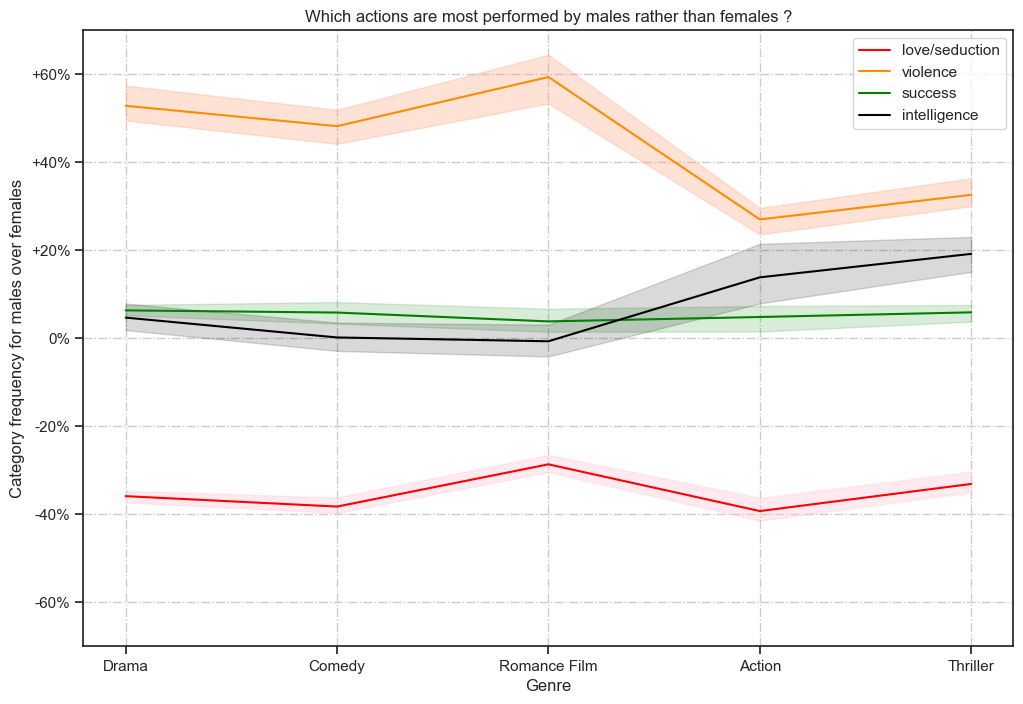

In [56]:
f, ax = plt.subplots(figsize = (12,8))
ax.grid(True, linestyle = '-.')
ax.set_ylabel('Category frequency for males over females')
ax.set_xlabel('Genre')
ax.set_ylim([-0.7, 0.7])
#ax.set_xlim([1914, 2013])
#ax.ticklabel_format(style='+', axis ='y')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
#plt.title('Male over female ratio of occurence frequencies by action\'s category')
ax.set_title('Which actions are most performed by males rather than females ?')
sns.lineplot(ax = ax, x = genres, y = Mean_ls, color = 'red', label = 'love/seduction')
ax.fill_between(x = genres, y1 = Lower_ls, y2=Upper_ls, color ='pink', alpha = 0.3)

sns.lineplot(ax = ax, x = genres, y = Mean_v, color = 'darkorange', label = 'violence')
ax.fill_between(x = genres, y1 = Lower_v, y2=Upper_v, color ='lightsalmon', alpha = 0.3)

sns.lineplot(ax = ax, x = genres, y = Mean_s, color = 'green', label = 'success')
ax.fill_between(x = genres, y1 = Lower_s, y2=Upper_s, color ='green', alpha = 0.15)

sns.lineplot(ax = ax, x =genres, y = Mean_i, color = 'black', label = 'intelligence')
ax.fill_between(x = genres, y1 = Lower_i, y2=Upper_i, color ='black', alpha = 0.15)

In [47]:
genres = ['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller']

conditions = char_description_total['Movie genres'] == '' 
for i in range(len(genres)):
    conditions = conditions | (char_description_total['Movie genres'] == genres[i])

df_genres_total = char_description_total[conditions]

In [48]:
# keep enloy actions that are in the lists
all_actions = love_seduction + violence + intelligence + success

def is_in_all_actions(action):
    return action in all_actions

df_genres_total = df_genres_total[df_genres_total['action'].apply(is_in_all_actions)]

In [49]:
def return_category(action):
    if action in love_seduction:
        return 'love/seduction'
    if action in violence:
        return 'violence'
    if action in success:
        return 'success'
    if action in intelligence:
        return 'intelligence'

df_genres_total['category'] = df_genres_total['action'].apply(return_category)

In [51]:
df_genres_total['one'] = 1

In [60]:
DATA_df = pd.DataFrame.from_dict({'ratio-1': Mean_ls + Mean_v + Mean_s + Mean_i,
                                  'lower': Lower_ls + Lower_v + Lower_s + Lower_i,
                                  'upper': Upper_ls + Upper_v + Upper_s + Upper_i, 
                                  'genre': genres*4, 
                                  'category': ['love/seduction']*5+['violence']*5+['success']*5+['intelligence']*5})

In [3]:
DATA_df = pd.read_csv('genre_analysis.csv')

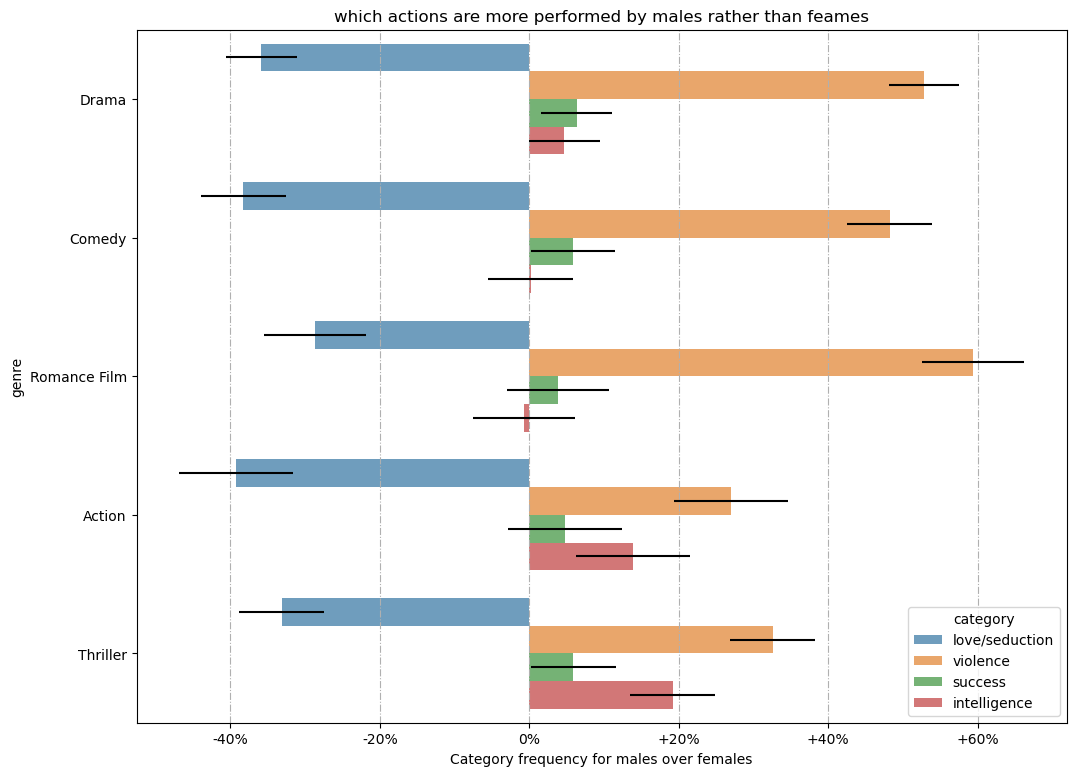

In [12]:
f, ax = plt.subplots(figsize=(12,9))
ax.set_title('which actions are more performed by males rather than feames')
ax.grid(True, linestyle = '-.')
# build xerr
genres = ['Drama', 'Comedy', 'Romance Film', 'Action', 'Thriller']
xerr = []
for genre in genres:
    xerr.append((DATA_df[DATA_df['genre']==genre]['upper']-DATA_df[DATA_df['genre']==genre]['lower']).mean())

sns.barplot(ax = ax, x = 'ratio-1', y = 'genre', data = DATA_df, alpha = 0.7, 
            xerr = xerr, hue = 'category')
ax.set_xlabel('Category frequency for males over females')
ax.xaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))

#ax.fill_between(y = 'Drama', )

#plt.bar(x = 0, height = 0, xerr = Lower_ls + Lower_v + Lower_s + Lower_i)
#plt.errorbar(x=[0, 1, 2, 3, 4],y=df['mean'],
 #           yerr=yerr, fmt='none', c= 'r')

In [ ]:
sns.barplot(x = 'Movie genres', y = Mean_ls, color = 'red', alpha = 0.3)

<AxesSubplot:title={'center':'Which actions are most performed by males rather than females ?'}, xlabel='Genre', ylabel='Category frequency for males over females'>

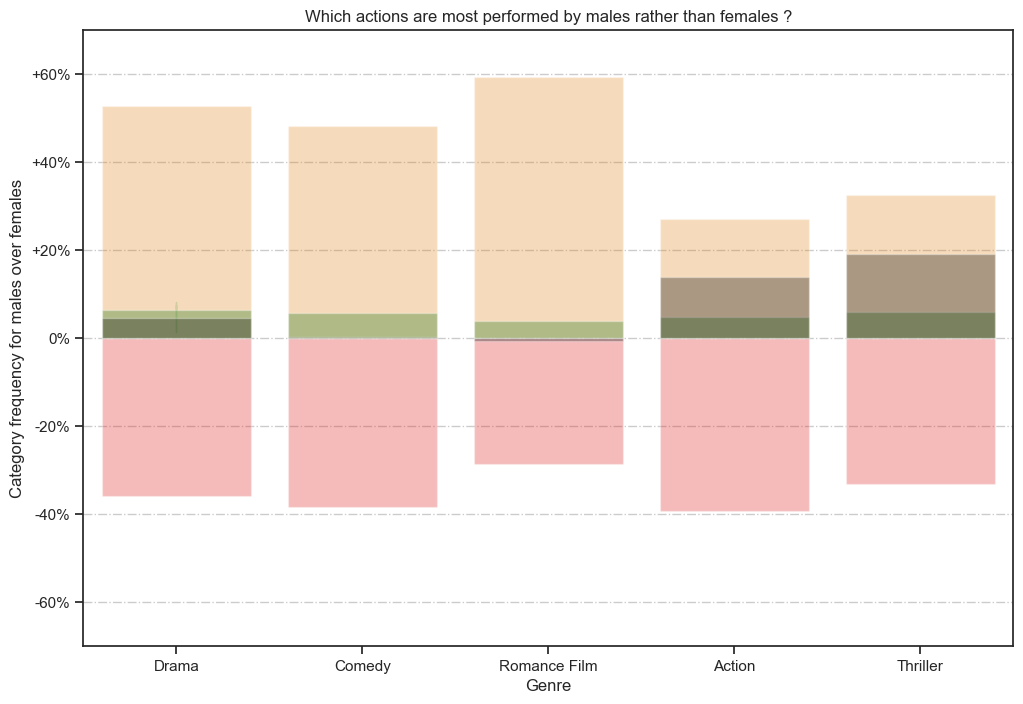

In [118]:
f, ax = plt.subplots(figsize = (12,8))
ax.grid(True, linestyle = '-.')
ax.set_ylabel('Category frequency for males over females')
ax.set_xlabel('Genre')
ax.set_ylim([-0.7, 0.7])
#ax.set_xlim([1914, 2013])
#ax.ticklabel_format(style='+', axis ='y')
ax.yaxis.set_major_formatter(FuncFormatter(lambda y, _: '+'*int(y>0)  +'{:.0%}'.format(y)))
#plt.title('Male over female ratio of occurence frequencies by action\'s category')
ax.set_title('Which actions are most performed by males rather than females ?')
sns.barplot(ax = ax, x = genres, y = Mean_ls, color = 'red', alpha = 0.3)
#ax.fill_between(x = genres, y1 = Lower_ls, y2=Upper_ls, color ='pink', alpha = 0.3)

sns.barplot(ax = ax, x = genres, y = Mean_v, color = 'darkorange', alpha = 0.3)
#ax.fill_between(x = genres, y1 = Lower_v, y2=Upper_v, color ='lightsalmon', alpha = 0.3)

sns.barplot(ax = ax, x = genres, y = Mean_s, color = 'green', alpha = 0.3)
ax.fill_between(x = 'Drama', y1 = Lower_s, y2=Upper_s, color ='green', alpha = 0.15)

sns.barplot(ax = ax, x = genres, y = Mean_i, color = 'black', alpha = 0.3)
#ax.fill_between(x = genres, y1 = Lower_i, y2=Upper_i, color ='black', alpha = 0.15)